In [16]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import re
import matplotlib.pyplot as plt
%matplotlib inline 

import sys
import os

In [17]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

In [6]:
business = pd.read_excel('yelp-dataset/yelp_data_business.xlsx')

In [7]:
review = pd.read_csv('yelp-dataset/yelp_data_review.csv')

In [9]:
business['business_id'] = business['business_id'].astype('category')

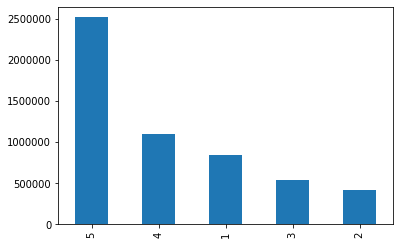

In [10]:
review['stars'].value_counts().plot(kind='bar')

In [14]:
## Change the reviews type to string
review['text'] = review['text'].astype(str)
  
## Lowercase all reviews
review['text'] = review['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
review['text'][2] 

"i have to say that this office really has it together, they are so organized and friendly! dr. j. phillipp is a great dentist, very friendly and professional. the dental assistants that helped in my procedure were amazing, jewel and bailey helped me to feel comfortable! i don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which i knew nothing about before this visit! i highly recommend this office for the nice synergy the whole office has!"

In [15]:
## Remove punctuation
review['text'] = review['text'].str.replace('[^\w\s]','')
review['text'][2]

'i have to say that this office really has it together they are so organized and friendly dr j phillipp is a great dentist very friendly and professional the dental assistants that helped in my procedure were amazing jewel and bailey helped me to feel comfortable i dont have dental insurance but they have this insurance through their office you can purchase for 80 something a year and this gave me 25 off all of my dental work plus they helped me get signed up for care credit which i knew nothing about before this visit i highly recommend this office for the nice synergy the whole office has'

In [16]:
stop = stopwords.words('english')
review['text'] = review['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
review['text'][2]

'say office really together organized friendly dr j phillipp great dentist friendly professional dental assistants helped procedure amazing jewel bailey helped feel comfortable dont dental insurance insurance office purchase 80 something year gave 25 dental work plus helped get signed care credit knew nothing visit highly recommend office nice synergy whole office'

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tribh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
st = PorterStemmer()
review['text'] = review['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
review['text'][2]

'say offic realli togeth organ friendli dr j phillipp great dentist friendli profession dental assist help procedur amaz jewel bailey help feel comfort dont dental insur insur offic purchas 80 someth year gave 25 dental work plu help get sign care credit knew noth visit highli recommend offic nice synergi whole offic'

In [ ]:
## Define a function which can be applied to calculate the score for the whole dataset
 
def senti(x):
    return TextBlob(x).sentiment  
 
review['senti_score'] = review['text'].apply(senti)
 
review.senti_score.head()

In [11]:
review_senti = review
review_senti['count'] = 1 

In [12]:
def fun_polarity(row):
    phrase = row
    matches = re.findall('[-+]?\d*\.\d+|\d+', phrase)
    return(float(matches[0]))

review_senti['polarity'] = review_senti['senti_score'].apply(lambda row: fun_polarity(row))

In [13]:
def fun_polarity(row):
    phrase = row
    matches = re.findall('[-+]?\d*\.\d+|\d+', phrase)
    if(float(matches[0]) >= 5.0):
        return(5.0)
    else:
        return(float(matches[1]) + 0.00001)

review_senti['subjectivity'] = review_senti['senti_score'].apply(lambda row: fun_polarity(row))

In [14]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=review_senti.loc[x.index, 'subjectivity'])

# Define a dictionary with the functions to apply for a given column:
f = {'useful': ['sum'], 'funny': ['sum'], 'cool': ['sum'], 'count': ['sum'], 'stars' : wm }

# Groupby and aggregate with your dictionary:
senti_data = review_senti.groupby(["business_id"], as_index=False).agg(f)

In [15]:
data = {'business_id' : senti_data['business_id'], 'count' : senti_data['count']['sum'], 'useful' : senti_data['useful']['sum'] , 'funny': senti_data['funny']['sum'], 'cool': senti_data['cool']['sum'], 'weighted_stars': senti_data['stars']['<lambda>']}
sentiment_data = pd.DataFrame(data)
sentiment_data

,business_id,count,useful,funny,cool,weighted_stars
0,--7zmmkVg-IMGaXbuVd0SQ,59,86,30,65,3.948300
1,--8LPVSo5i0Oo61X01sV9A,4,11,0,0,3.999245
2,--9QQLMTbFzLJ_oT-ON3Xw,13,8,3,4,3.649388
3,--9e1ONYQuAa-CB_Rrw7Tw,1661,1770,917,1183,4.145556
4,--DdmeR16TRb3LsjG0ejrQ,6,18,15,14,3.321625
...,...,...,...,...,...,...
133622,zzuOCWxuY39YJ1wnTwQ0Lg,3,7,0,0,1.000000
133623,zzwaS0xn1MVEPEf0hNLjew,72,87,47,52,3.509772
133624,zzwhN7x37nyjP0ZM8oiHmw,57,54,8,30,4.190880
133625,zzwicjPC9g246MK2M1ZFBA,76,122,40,41,3.048008


In [36]:
model_prem_data = business.merge(sentiment_data, left_on='business_id', right_on='business_id')

In [23]:
model_prem_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', 'city', 'state',
       'latitude', 'longitude', 'stars', 'attributes.GoodForKids',
       'attributes.RestaurantsDelivery', 'attributes.Caters',
       'attributes.WiFi', 'attributes.RestaurantsTakeOut',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsGoodForGroups', 'attributes.OutdoorSeating',
       'attributes.HasTV', 'attributes.BikeParking',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsPriceRange2',
       'attributes.BusinessAcceptsBitcoin', 'attributes.ByAppointmentOnly',
       'attributes.AcceptsInsurance', 'attributes.GoodForDancing',
       'attributes.CoatCheck', 'attributes.HappyHour',
       'attributes.BYOBCorkage', 'attributes.DriveThru',
       'attributes.WheelchairAccessible', 'attributes.AgesAllowed',
       'attributes.Smoking', 'attributes.DogsAllowed', 'attributes.Corkage',
       'attributes.BYOB', 'attrib

In [24]:
model_prem_data['attributes.BusinessAcceptsCreditCards'].value_counts()

True     98590
False     5534
None        81
Name: attributes.BusinessAcceptsCreditCards, dtype: int64

In [25]:
model_prem_data.apply(lambda col: col.isna().sum())

Unnamed: 0                                    0
Unnamed: 0.1                                  0
business_id                                   0
city                                          1
state                                         0
latitude                                      0
longitude                                     0
stars                                         0
attributes.GoodForKids                    91993
attributes.RestaurantsDelivery           101870
attributes.Caters                        106821
attributes.WiFi                          102519
attributes.RestaurantsTakeOut             96594
attributes.BusinessAcceptsCreditCards     27743
attributes.RestaurantsTableService       122312
attributes.RestaurantsGoodForGroups      100833
attributes.OutdoorSeating                100444
attributes.HasTV                         104298
attributes.BikeParking                    76937
attributes.RestaurantsReservations       102246
attributes.RestaurantsPriceRange2       

In [26]:
model_prem_data['weighted_stars'] = model_prem_data['weighted_stars'].apply(lambda row: float('%s' % float('%.3g' % row)))

In [27]:
model_prem_data['attributes.BusinessAcceptsCreditCards'] =  model_prem_data['attributes.BusinessAcceptsCreditCards'][model_prem_data['attributes.BusinessAcceptsCreditCards'] != 'None']

In [28]:
model_prem_data = model_prem_data.dropna(subset=['attributes.BusinessAcceptsCreditCards']) 

In [29]:
def calc_bool(row):
    if(row == 'True'):
        return(int(1))
    else:
        return(int(0))

model_prem_data['attributes.BusinessAcceptsCreditCards'] = model_prem_data['attributes.BusinessAcceptsCreditCards'].apply(lambda col: calc_bool(col))

In [30]:
model_prem_data['attributes.BusinessAcceptsCreditCards'].value_counts()

1    98590
0     5534
Name: attributes.BusinessAcceptsCreditCards, dtype: int64

In [31]:
model_data = model_prem_data[['business_id', 'city', 'state', 'latitude', 'longitude','stars', 'attributes.BusinessAcceptsCreditCards', 'count', 'useful', 'funny', 'cool', 'weighted_stars']]

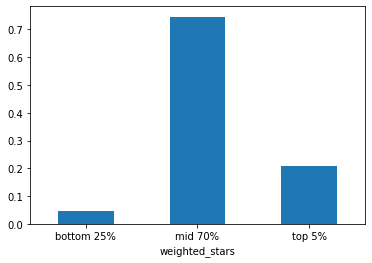

In [33]:
prob = model_data['weighted_stars'].value_counts()
prob /= prob.sum()
category_classes = pd.qcut(prob, q=[0, .25, 0.95, 1.], 
                 labels=['bottom 25%', 'mid 70%', 'top 5%'])
prob_groups = prob.groupby(category_classes).sum()
prob_groups.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [35]:
prob_groups

weighted_stars
bottom 25%    0.046781
mid 70%       0.745553
top 5%        0.207666
Name: weighted_stars, dtype: float64

In [ ]:
model_data.to_csv("model_data.csv")